In [1]:
import pycurl
import StringIO
import time
import csv

def oneday(start,symbol):
    st = time.strptime(start, '%Y-%m-%d %H:%M:%S')
    pytime1 = time.mktime(st)*1000
    pytime2 = pytime1+60*60*12*1000
    list1 = getprice(pytime1,symbol)
    list2 = getprice(pytime2,symbol)
    listall = list1+list2
    
    for l in listall:
        st = time.localtime(l[0]/1000)
        l[0] = time.strftime('%Y-%m-%d %H:%M:%S', st)       

    csvfile = open(symbol+start[:10]+'.csv', 'wb')
    writer = csv.writer(csvfile)
    writer.writerow(['MTS', 'OPEN', 'CLOSE', 'HIGH', 'LOW', 'VOLUME'])
    writer.writerows(listall)
    csvfile.close()

def getprice(pytime,symbol):
    url='https://api.bitfinex.com/v2/candles/trade:1m:'+symbol+'/hist?limit=720&start='+str(int(pytime))+'&sort=1'
    c=pycurl.Curl()
    c.setopt(c.URL, url)
    b = StringIO.StringIO()
    c.setopt(c.WRITEFUNCTION, b.write)
    c.perform()
    price=eval(b.getvalue())
    return price

In [2]:
oneday('2017-12-14 00:00:00','tBTCUSD')

In [3]:
oneday('2017-12-15 00:00:00','tBTCUSD')

In [4]:
# Input data files are available in the "../input/" directory.
import pandas as pd
from subprocess import check_output

print check_output(["ls", "."]).decode("utf8")

AR.ipynb
Bitcoin Price Prediction.ipynb
tBTCUSD2017-12-14.csv
tBTCUSD2017-12-15.csv



In [5]:
oneday = pd.read_csv("tBTCUSD2017-12-14.csv", index_col='MTS')  # 读取数据，pd.read_csv默认生成DataFrame对象
oneday.index = pd.to_datetime(oneday.index)   # 将字符串索引转换成时间索引
# cols = ["OPEN", "CLOSE", "HIGH", "LOW"]
# oneday[cols] = (oneday[cols] - oneday[cols].mean()) / (oneday[cols].max() - oneday[cols].min())
openprice = oneday['OPEN']  # 生成pd.Series对象
closeprice = oneday['CLOSE']
highprice = oneday['HIGH']
lowprice = oneday['LOW']

In [6]:
oneday.head()

,OPEN,CLOSE,HIGH,LOW,VOLUME
MTS,,,,,
2017-12-14 00:00:00,16648.0,16651.0,16680.0,16613.0,98.959339
2017-12-14 00:01:00,16650.0,16676.0,16701.0,16650.0,81.457980
2017-12-14 00:02:00,16676.0,16688.0,16770.0,16676.0,124.565816
2017-12-14 00:03:00,16689.0,16770.0,16770.0,16686.0,35.940528
2017-12-14 00:04:00,16767.0,16768.0,16780.0,16767.0,71.088120


In [8]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 移动平均图
def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean()
    # 对size个数据进行加权移动平均
    #rol_weighted_mean = pd.ewma(timeSeries, span=size)
    rol_weighted_mean = timeSeries.ewm(span=size).mean()
    
    timeSeries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

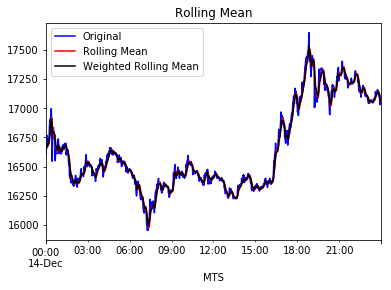

In [9]:
draw_trend(lowprice, 10)

In [10]:
def testStationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

In [11]:
testStationarity(lowprice)

Test Statistic                   -1.331000
p-value                           0.614873
#Lags Used                        2.000000
Number of Observations Used    1437.000000
Critical Value (5%)              -2.863553
Critical Value (1%)              -3.434909
Critical Value (10%)             -2.567842
dtype: float64

In [12]:
# 自相关和偏相关图，默认阶数为31阶
def draw_acf_pacf(ts, lags=31):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.show()

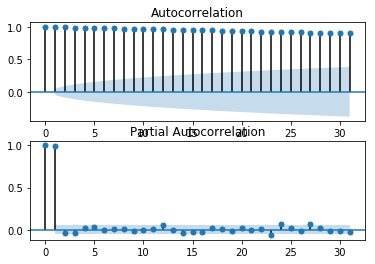

In [13]:
draw_acf_pacf(lowprice)

In [14]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(lowprice, order=(1, 2)) 
result_arma = model.fit( disp=-1, method='css')

In [15]:
predict_ts = result_arma.predict()

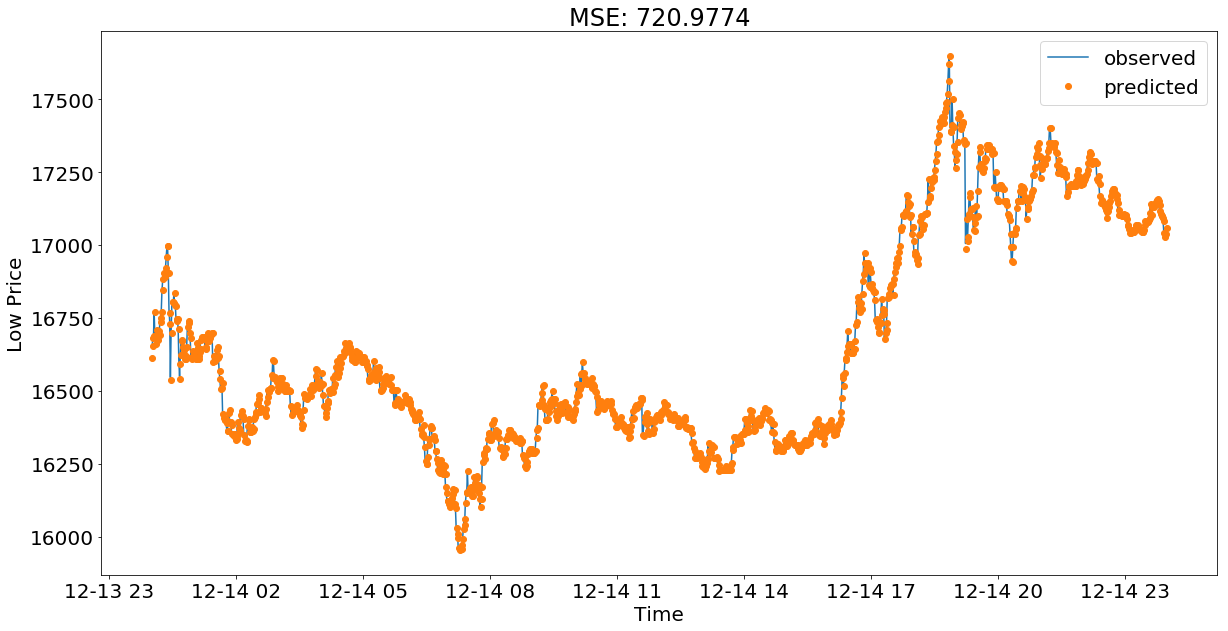

In [52]:
import matplotlib
fig, ax = plt.subplots(figsize=(20, 10))
lowprice = lowprice[predict_ts.index]  # 过滤没有预测的记录
ax.set(title='MSE: %.4f'% (sum((predict_ts-lowprice)**2)/lowprice.size), xlabel='Time', ylabel='Low Price')
ax.plot(lowprice, '-', label='observed')
ax.plot(predict_ts,'o', label='predicted')
legend = ax.legend(loc='best')
legend.get_frame().set_facecolor('w')

font = {'family' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

plt.show()

In [34]:
test = pd.read_csv("tBTCUSD2017-12-15.csv", index_col='MTS')  # 读取数据，pd.read_csv默认生成DataFrame对象
test.index = pd.to_datetime(test.index)   # 将字符串索引转换成时间索引

# openprice = oneday['OPEN']  # 生成pd.Series对象
# closeprice = oneday['CLOSE']
# highprice = oneday['HIGH']
test_lowprice = test['LOW']

In [45]:
from sklearn.metrics import mean_squared_error

history = [x for x in lowprice]
predictions = list()

In [46]:
# predict the lower price for next minute
print('Printing Predicted vs Expected Values...')
print('\n')
#for t in range(len(test_lowprice)):
for t in range(120): # next two hours
    model = ARMA(history, order=(1,2))
    model_fit = model.fit(disp=-1)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test_lowprice[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))
    print('predicted=%f, expected=%f' % (yhat, obs))

Printing Predicted vs Expected Values...


predicted=17058.028596, expected=17058.000000
predicted=17056.846208, expected=17062.000000
predicted=17060.995802, expected=17064.000000
predicted=17063.192869, expected=17064.000000
predicted=17062.965853, expected=17068.000000
predicted=17067.044962, expected=17039.000000
predicted=17036.691546, expected=17033.000000
predicted=17029.989138, expected=17031.000000
predicted=17029.666490, expected=17030.000000
predicted=17028.910131, expected=17030.000000
predicted=17028.902967, expected=17030.000000
predicted=17028.956932, expected=17031.000000
predicted=17030.001386, expected=17060.000000
predicted=17060.398531, expected=17060.000000
predicted=17060.515075, expected=17069.000000
predicted=17068.153197, expected=17080.000000
predicted=17079.830800, expected=17090.000000
predicted=17089.916357, expected=17106.000000
predicted=17106.093544, expected=17095.000000
predicted=17094.086011, expected=17080.000000
predicted=17077.368444, expected=1710

/Users/Crystal/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=17354.828181, expected=17375.000000
predicted=17375.874241, expected=17376.000000
predicted=17375.595518, expected=17398.000000
predicted=17397.514122, expected=17400.000000
predicted=17399.839152, expected=17400.000000
predicted=17398.559455, expected=17431.000000
predicted=17430.995060, expected=17442.000000
predicted=17442.848533, expected=17450.000000
predicted=17449.368752, expected=17475.000000
predicted=17475.088796, expected=17475.000000
predicted=17474.893444, expected=17490.000000
predicted=17489.158899, expected=17486.000000
predicted=17485.135611, expected=17451.000000
predicted=17447.518040, expected=17430.000000
predicted=17425.494641, expected=17450.000000
predicted=17448.606933, expected=17453.000000
predicted=17453.054780, expected=17466.000000
predicted=17465.336666, expected=17452.000000
predicted=17450.511766, expected=17400.000000
predicted=17395.084917, expected=17400.000000
predicted=17395.751836, expected=17409.000000
predicted=17408.391194, expected=1

In [47]:
error = mean_squared_error(test_lowprice[:120], predictions)

#print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

predictions_series = pd.Series(predictions, index = test_lowprice.index[:120])

Printing Mean Squared Error of Predictions...
Test MSE: 351.578981


In [48]:
import matplotlib
fig, ax = plt.subplots(figsize=(20, 10))
ax.set(title='Low Price Prediction', xlabel='Time', ylabel='Low Price')
ax.plot(lowprice, '-', label='observed')
ax.plot(test_lowprice[:120], 'o', label='true label (one-step out-of-sample forecast)')
ax.plot(predictions_series, 'g', label='predicted label (one-step out-of-sample forecast)')
legend = ax.legend(loc='best')
legend.get_frame().set_facecolor('w')

font = {'family' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

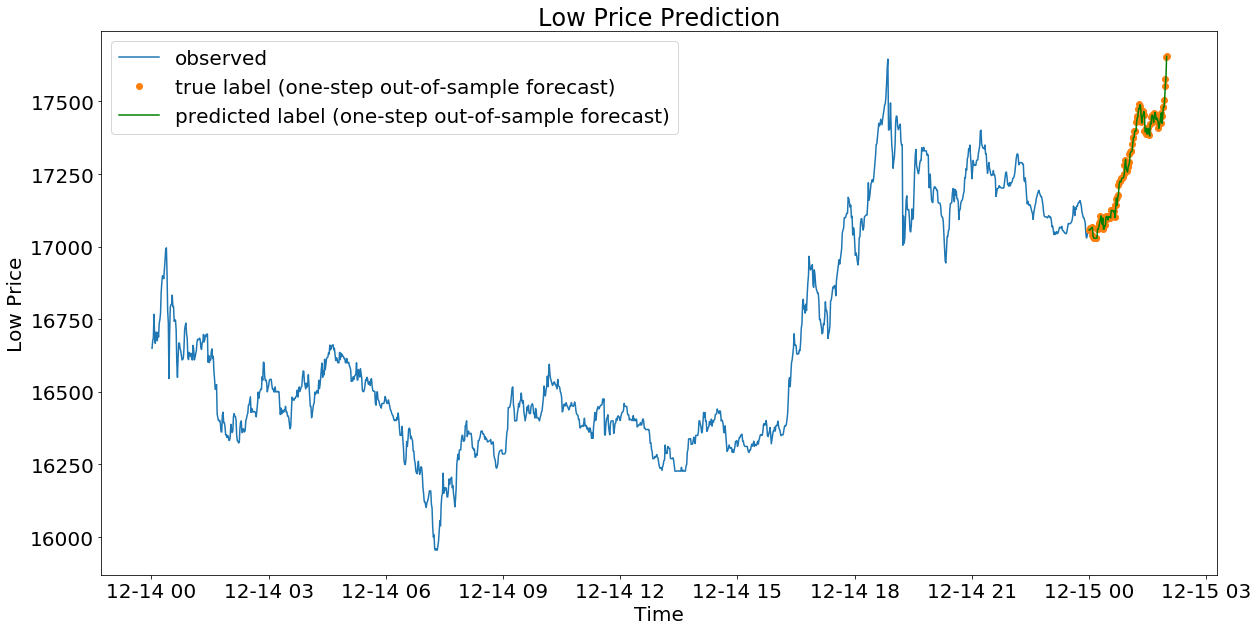

In [49]:
plt.show()

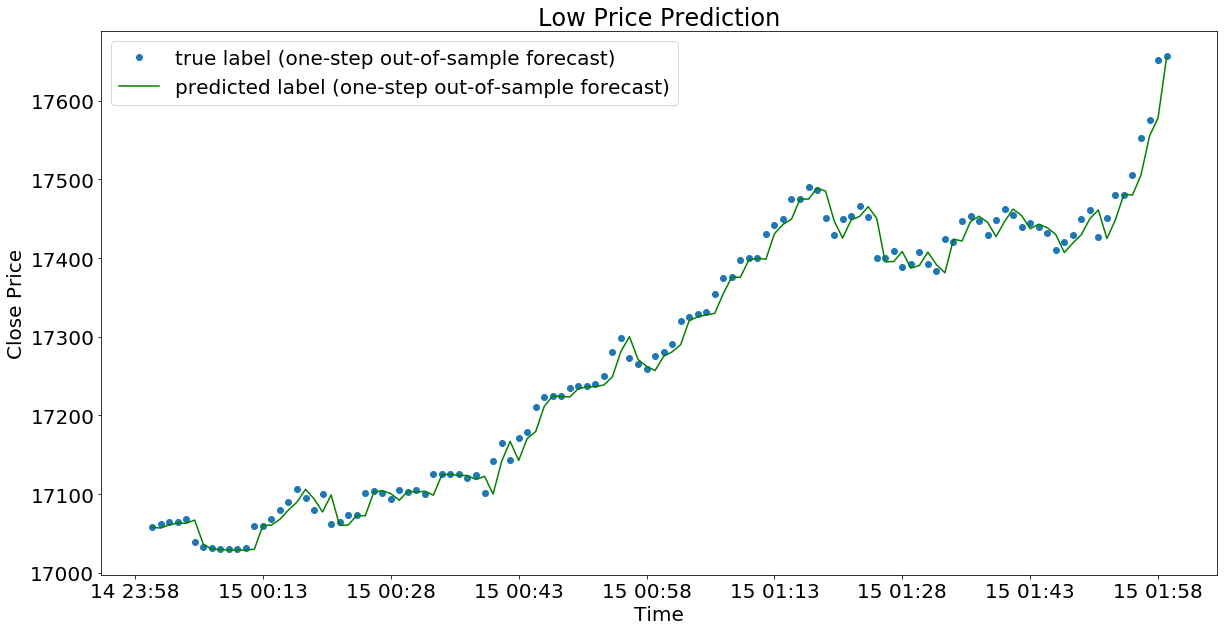

In [50]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set(title='Low Price Prediction', xlabel='Time', ylabel='Close Price')
#ax.plot(lowprice[:120], '-', label='observed')
ax.plot(test_lowprice[:120], 'o', label='true label (one-step out-of-sample forecast)')
ax.plot(predictions_series[:120], 'g', label='predicted label (one-step out-of-sample forecast)')
legend = ax.legend(loc='best')
legend.get_frame().set_facecolor('w')

font = {'family' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
plt.show()